In [ ]:
! pip install --upgrade sklearn
! pip install statsmodels

# Capstone 1 EDA

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import t, norm
from scipy import stats
from scipy.stats import pearsonr
from statsmodels.graphics.regressionplots import abline_plot
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.formula.api import ols
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f} ".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    ax.margins(0.1, 0.2)
    
"""
methods
"""
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func=np.mean, mu=0, size=1):
    """Draw bootstrap replicates."""
    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    return bs_replicates

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, 1 + n)/ n

    return x, y

def routs(sr, iq_range=0.5):
    """
    This function removes outliers based on median based outliers.
    Given a  1-D array this function will return the array 
    """
    pcnt = (1 - iq_range) / 2
    qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
    iqr = qhigh - qlow
    fitted = routs(m.fittedvalues)
    resid = routs(m.resid)

    p = pd.DataFrame({"resid":resid,"fitted":m.fittedvalues})
    p = p.dropna()
    return sr[ (sr - median).abs() <= iqr]
    
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.20)
    q3 = df_in[col_name].quantile(0.8)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in[(df_in.loc[:,col_name] > fence_low) & (df_in.loc[:,col_name] < fence_high)]
    return df_out

In [3]:
white = pd.read_csv("./data/winequality-white.csv", sep=";")
red = pd.read_csv("./data/winequality-red.csv", sep=';')

# print outliers
print(white.isnull().sum())
print(red.isnull().sum())

white.rename(columns={"fixed acidity":'fixed_acidity', "volatile acidity":"vol_acidity", 
                      'citric acid':"citric_acid", "free sulfur dioxide":"free_sul_dioxide", 
                      "total sulfur dioxide":"total_SD", "residual sugar": "resid_sugar"}, inplace=True)
red.rename(columns={"fixed acidity":'fixed_acidity', "volatile acidity":"vol_acidity", 
                    'citric acid':"citric_acid", "free sulfur dioxide":"free_sul_dioxide", 
                    "total sulfur dioxide":"total_SD", "residual sugar": "resid_sugar"}, inplace=True)
cols = white.columns.tolist()

whiteH = white[white["quality"]>=7]
redH = red[red["quality"]>=7]

whiteM = white[(white["quality"]>=5) & (white["quality"]<=6)]
whiteL = white[white['quality']<=4]

redM = red[(red["quality"]>=5) & (red["quality"]<=6)]
redL = red[red['quality']<=4]
whiteH.loc[:,'group'] = 'H'
redH.loc[:,'group'] = 'H'
whiteM.loc[:,'group'] = 'M'
whiteL.loc[:,'group'] = 'L'
redM.loc[:,'group'] = 'M'
redL.loc[:,'group'] = 'L'
redn = redM.append(redL)
redn = redn.append(redH)
whiten = whiteM.append(whiteL)
whiten = whiten.append(whiteH)

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


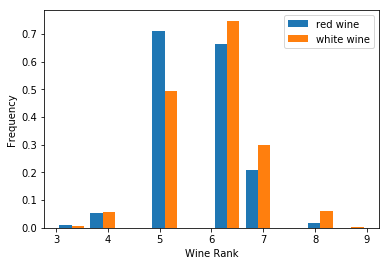

In [4]:

fig, ax = plt.subplots()

n, bins, patches = plt.hist([red.quality, white.quality], normed=True, label=['red wine', 'white wine'])
plt.xlabel('Wine Rank')
plt.ylabel('Frequency')

plt.legend(loc='upper right')
plt.savefig('histboth.png', dpi=600)

In [5]:
sam_statsw = white.groupby(['quality'])\
                          [white.columns.tolist()].agg({'mean': np.mean, 'stddev': np.std, 
                                                        'var': np.var, 'len': len})
sam_statsr = red.groupby(['quality'])\
                          [red.columns.tolist()].agg({'mean': np.mean, 'stddev': np.std, 
                                                      'var': np.var, 'len': len})

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


### Interactions for prediction
Based on the matrix for Red wine we may have strong interactions between variables which would lend us a hand in building linear regression models. We will test these later on. The list below is a guide:

* pH and OH
* pH and citric acid
* citric acid and vol_acidity
* alcohol and density
* pH and density
* alcohol and cholrides


In [6]:
redcorr = red.corr()
whitecorr = white.corr()


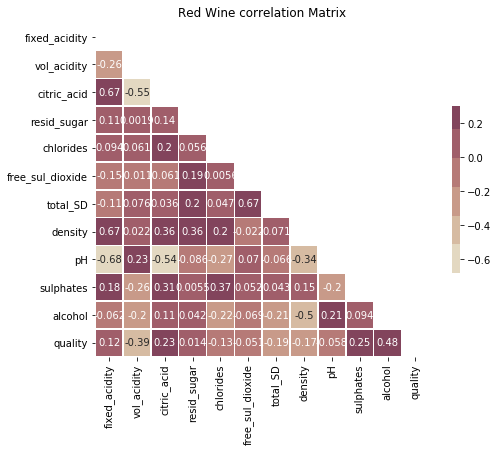

In [7]:

# Tweak the visual presentation
f, ax = plt.subplots(figsize=(8, 8))
ax.xaxis.grid(True)
ax.set(ylabel="")

# Generate a custom diverging colormap
cmap = sns.cubehelix_palette(8, start=0.3)
# Draw the heatmap with the mask and correct aspect ratio
mask = np.zeros_like(redcorr)
mask[np.triu_indices_from(mask)] = True
hm = sns.heatmap(redcorr, vmax=.3, mask=mask, center=0, cmap=cmap,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Red Wine correlation Matrix")
plt.gcf().subplots_adjust(bottom=0.3)
plt.savefig('red_matrix.png')


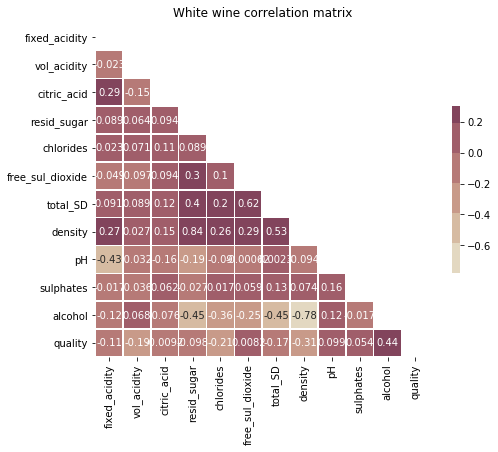

In [8]:

# Tweak the visual presentation
f, ax = plt.subplots(figsize=(8, 8))
ax.xaxis.grid(True)
ax.set(ylabel="")
# Draw the heatmap with the mask and correct aspect ratio
mask = np.zeros_like(whitecorr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(whitecorr, vmax=.3, mask=mask, center=0,cmap=cmap,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.gcf().subplots_adjust(bottom=0.3)
plt.title("White wine correlation matrix")
plt.savefig('white_matrix.png')


In [9]:
print("length of: red high group {}, white high group {}".format(len(redH), len(whiteH)))

length of: red high group 217, white high group 1060


In [10]:
redn.describe()

,fixed_acidity,vol_acidity,citric_acid,resid_sugar,chlorides,free_sul_dioxide,total_SD,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [11]:
redH.describe()

,fixed_acidity,vol_acidity,citric_acid,resid_sugar,chlorides,free_sul_dioxide,total_SD,density,pH,sulphates,alcohol,quality
count,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000
mean,8.847005,0.405530,0.376498,2.708756,0.075912,13.981567,34.889401,0.996030,3.288802,0.743456,11.518049,7.082949
std,1.999977,0.144963,0.194438,1.363026,0.028480,10.234615,32.572238,0.002201,0.154478,0.134038,0.998153,0.276443
min,4.900000,0.120000,0.000000,1.200000,0.012000,3.000000,7.000000,0.990640,2.880000,0.390000,9.200000,7.000000
25%,7.400000,0.300000,0.300000,2.000000,0.062000,6.000000,17.000000,0.994700,3.200000,0.650000,10.800000,7.000000
50%,8.700000,0.370000,0.400000,2.300000,0.073000,11.000000,27.000000,0.995720,3.270000,0.740000,11.600000,7.000000
75%,10.100000,0.490000,0.490000,2.700000,0.085000,18.000000,43.000000,0.997350,3.380000,0.820000,12.200000,7.000000
max,15.600000,0.915000,0.760000,8.900000,0.358000,54.000000,289.000000,1.003200,3.780000,1.360000,14.000000,8.000000


In [12]:
whiteH.describe()

,fixed_acidity,vol_acidity,citric_acid,resid_sugar,chlorides,free_sul_dioxide,total_SD,density,pH,sulphates,alcohol,quality
count,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000
mean,6.725142,0.265349,0.326057,5.261509,0.038160,34.550472,125.245283,0.992412,3.215132,0.500142,11.416022,7.174528
std,0.768798,0.094097,0.080288,4.290845,0.011145,13.797146,32.724848,0.002772,0.157185,0.133044,1.255209,0.391978
min,3.900000,0.080000,0.010000,0.800000,0.012000,5.000000,34.000000,0.987110,2.840000,0.220000,8.500000,7.000000
25%,6.200000,0.190000,0.280000,1.800000,0.031000,25.000000,101.000000,0.990500,3.100000,0.400000,10.700000,7.000000
50%,6.700000,0.250000,0.310000,3.875000,0.037000,33.000000,122.000000,0.991730,3.200000,0.480000,11.500000,7.000000
75%,7.200000,0.320000,0.360000,7.400000,0.044000,42.000000,146.000000,0.993605,3.320000,0.580000,12.400000,7.000000
max,9.200000,0.760000,0.740000,19.250000,0.135000,108.000000,229.000000,1.000600,3.820000,1.080000,14.200000,9.000000


In [13]:
redM.describe()

,fixed_acidity,vol_acidity,citric_acid,resid_sugar,chlorides,free_sul_dioxide,total_SD,density,pH,sulphates,alcohol,quality
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,8.254284,0.538560,0.258264,2.503867,0.088973,16.368461,48.946929,0.996867,3.311296,0.647263,10.252717,5.483700
std,1.682935,0.167679,0.187995,1.399633,0.047538,10.492335,32.714030,0.001815,0.152345,0.167334,0.972354,0.499924
min,4.700000,0.160000,0.000000,0.900000,0.034000,1.000000,6.000000,0.990070,2.860000,0.370000,8.400000,5.000000
25%,7.100000,0.410000,0.090000,1.900000,0.071000,8.000000,24.000000,0.995800,3.210000,0.540000,9.500000,5.000000
50%,7.800000,0.540000,0.240000,2.200000,0.080000,14.000000,40.000000,0.996800,3.310000,0.610000,10.000000,5.000000
75%,9.100000,0.640000,0.400000,2.600000,0.091000,22.000000,65.000000,0.997900,3.400000,0.700000,10.900000,6.000000
max,15.900000,1.330000,0.790000,15.500000,0.611000,72.000000,165.000000,1.003690,4.010000,1.980000,14.900000,6.000000


In [14]:
whiteM.describe()

,fixed_acidity,vol_acidity,citric_acid,resid_sugar,chlorides,free_sul_dioxide,total_SD,density,pH,sulphates,alcohol,quality
count,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000
mean,6.876060,0.277086,0.337877,6.797729,0.047740,35.962107,142.571272,0.994480,3.180720,0.487557,10.269808,5.601368
std,0.839049,0.095253,0.128304,5.248933,0.023256,16.740109,42.957893,0.002913,0.147352,0.107647,1.104035,0.489684
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987220,2.720000,0.230000,8.000000,5.000000
25%,6.300000,0.210000,0.260000,1.700000,0.037000,23.000000,111.000000,0.992300,3.080000,0.410000,9.400000,5.000000
50%,6.800000,0.260000,0.320000,6.200000,0.044000,34.000000,140.000000,0.994380,3.170000,0.470000,10.000000,6.000000
75%,7.400000,0.320000,0.400000,10.500000,0.051000,47.000000,173.000000,0.996595,3.260000,0.540000,11.000000,6.000000
max,14.200000,0.965000,1.660000,65.800000,0.346000,131.000000,344.000000,1.038980,3.810000,1.060000,14.000000,6.000000


In [15]:
whiteL.describe()

,fixed_acidity,vol_acidity,citric_acid,resid_sugar,chlorides,free_sul_dioxide,total_SD,density,pH,sulphates,alcohol,quality
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,7.180874,0.375984,0.307705,4.821038,0.050557,26.633880,130.232240,0.994343,3.183388,0.475956,10.173497,3.890710
std,1.171885,0.170525,0.157131,4.322845,0.028700,31.001858,62.373163,0.002504,0.168668,0.117847,1.027570,0.312858
min,4.200000,0.110000,0.000000,0.700000,0.013000,3.000000,10.000000,0.989200,2.830000,0.250000,8.000000,3.000000
25%,6.400000,0.260000,0.205000,1.350000,0.037500,9.000000,85.500000,0.992580,3.060000,0.380000,9.400000,4.000000
50%,6.900000,0.320000,0.300000,2.700000,0.046000,18.000000,119.000000,0.994100,3.160000,0.470000,10.100000,4.000000
75%,7.650000,0.460000,0.400000,7.500000,0.054000,33.500000,177.000000,0.996010,3.285000,0.540000,10.800000,4.000000
max,11.800000,1.100000,0.880000,17.550000,0.290000,289.000000,440.000000,1.000400,3.720000,0.870000,13.500000,4.000000


In [16]:
redL.describe()

,fixed_acidity,vol_acidity,citric_acid,resid_sugar,chlorides,free_sul_dioxide,total_SD,density,pH,sulphates,alcohol,quality
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,7.871429,0.724206,0.173651,2.684921,0.095730,12.063492,34.444444,0.996689,3.384127,0.592222,10.215873,3.841270
std,1.649284,0.247970,0.207406,1.723735,0.075121,9.076508,26.395123,0.001667,0.175100,0.224323,0.918178,0.368359
min,4.600000,0.230000,0.000000,1.200000,0.045000,3.000000,7.000000,0.993400,2.740000,0.330000,8.400000,3.000000
25%,6.800000,0.565000,0.020000,1.900000,0.068500,5.000000,13.500000,0.995655,3.300000,0.495000,9.600000,4.000000
50%,7.500000,0.680000,0.080000,2.100000,0.080000,9.000000,26.000000,0.996600,3.380000,0.560000,10.000000,4.000000
75%,8.400000,0.882500,0.270000,2.950000,0.094500,15.500000,48.000000,0.997700,3.500000,0.600000,11.000000,4.000000
max,12.500000,1.580000,1.000000,12.900000,0.610000,41.000000,119.000000,1.001000,3.900000,2.000000,13.100000,4.000000


In [17]:
print("The red mid group is {} times larger than the low group".format(len(redM)/len(redL)))
print("The white mid group is {} times larger than the low group".format(len(whiteM)/len(whiteL)))

The red mid group is 20.936507936507937 times larger than the low group
The white mid group is 19.972677595628415 times larger than the low group


In [18]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
np_scaledr = min_max_scaler.fit_transform(red)
np_scaledw = min_max_scaler.fit_transform(white)
df_normalizedr = pd.DataFrame(np_scaledr)
df_normalizedw = pd.DataFrame(np_scaledw)
df_normalizedr.columns = red.columns
df_normalizedw.columns = red.columns
df_normalizedr['quality'] = red['quality']
df_normalizedw['quality'] = white['quality']


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:5847: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  return_type=return_type, **kwds)


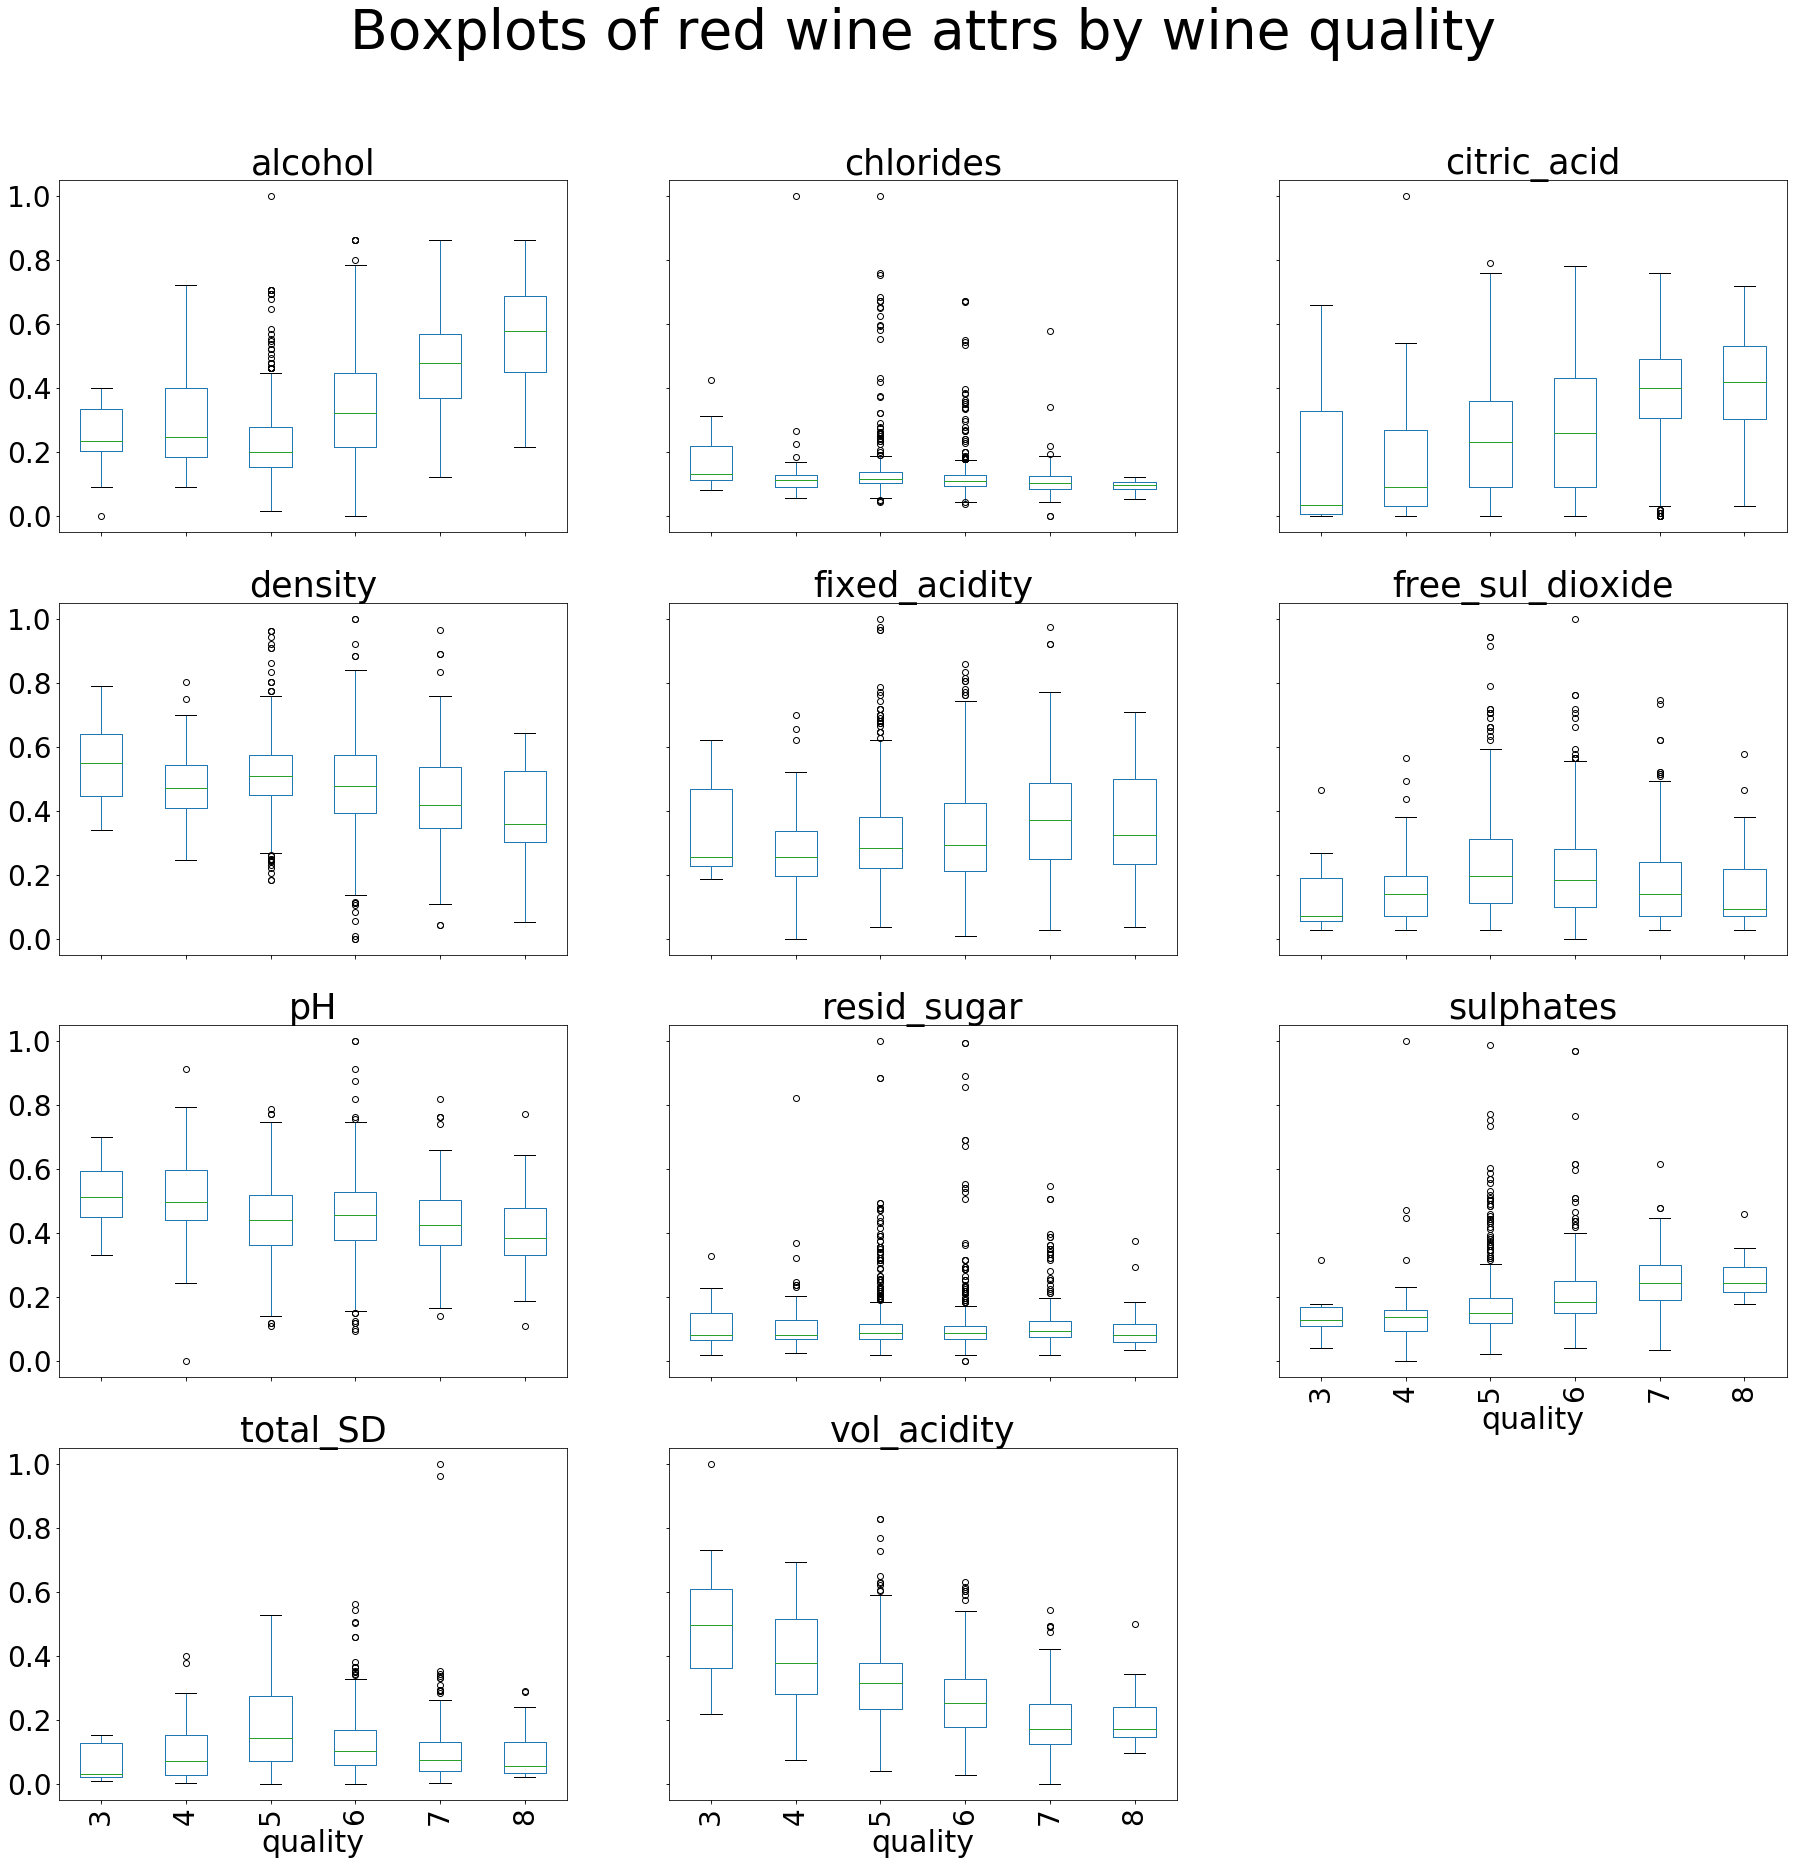

In [19]:
fig, axes = plt.subplots(figsize=(30, 30))
_ = df_normalizedr.boxplot(grid=False, by="quality", return_type='axes',rot=90, ax=axes, fontsize=28)
fig.suptitle("Boxplots of red wine attrs by wine quality", fontsize=55)
for i in _:
    i.title.set_fontsize(35)
    i.set_xlabel('quality', fontdict={'fontsize':30})
plt.savefig('redbox.jpg', quality=100)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:5847: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  return_type=return_type, **kwds)


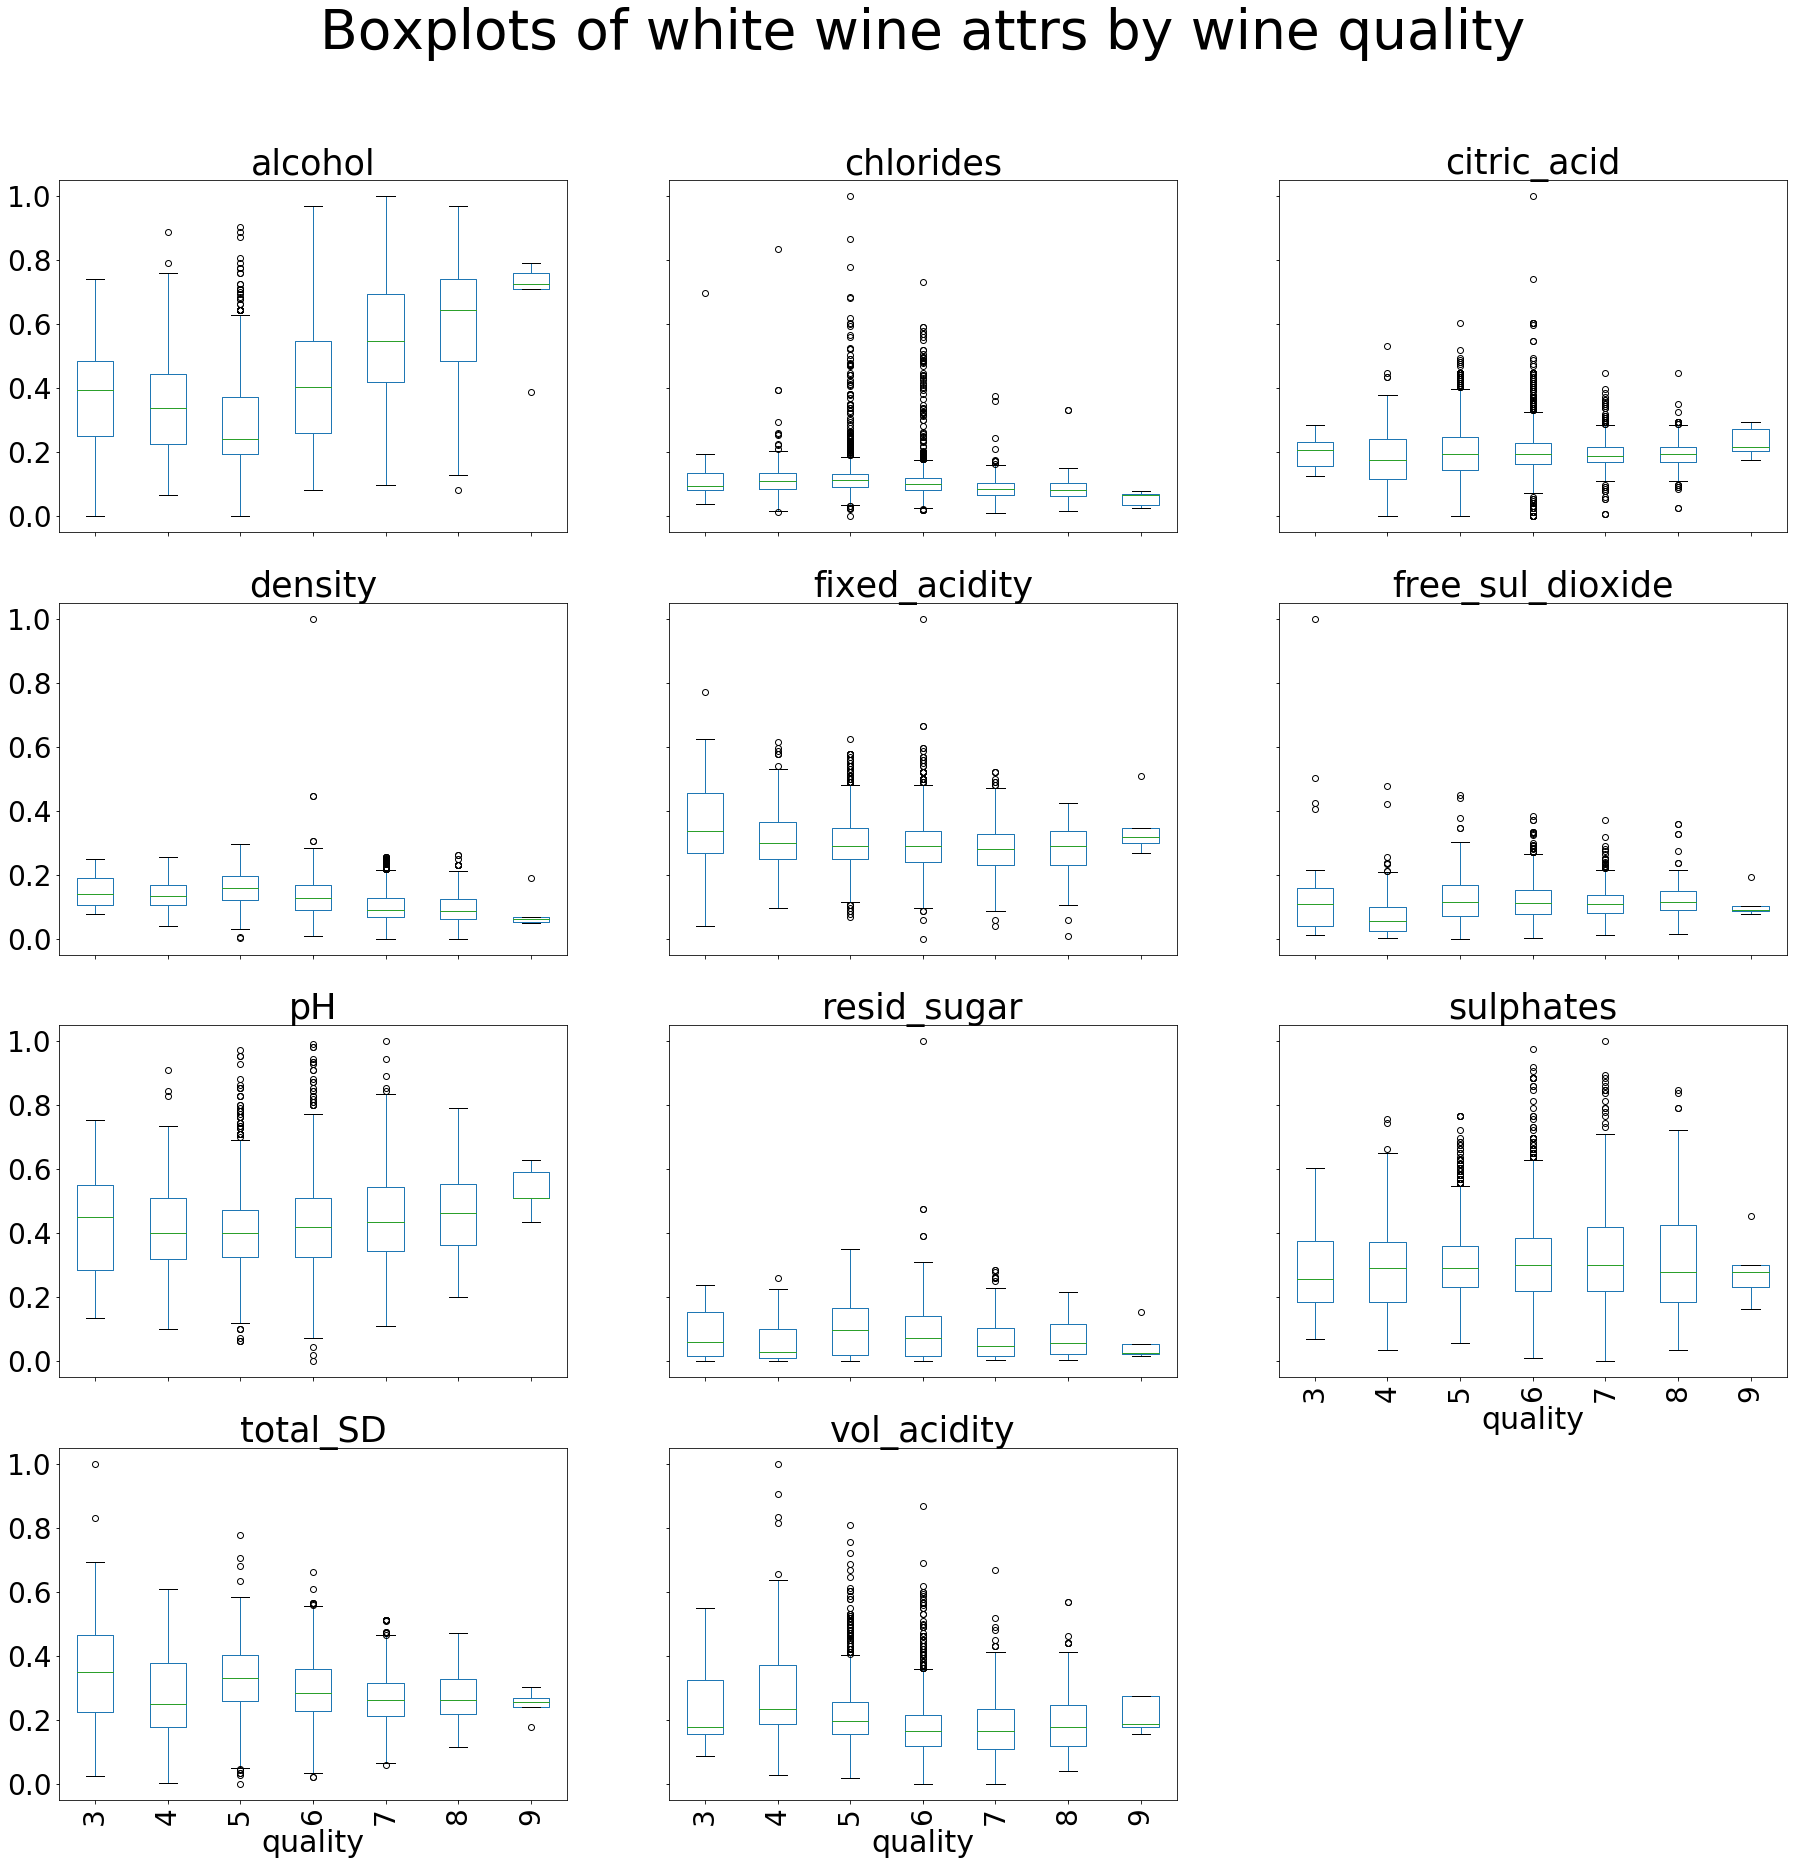

In [20]:
fig, axes = plt.subplots(figsize=(30, 30))
ax = df_normalizedw.boxplot(grid=False, by="quality", return_type='axes',rot=90, ax=axes, fontsize=28)
for i in ax:
    i.title.set_fontsize(35)
    i.set_xlabel('quality', fontdict={'fontsize':30})
fig.suptitle("Boxplots of white wine attrs by wine quality", fontsize=55)
plt.savefig('whitebox.jpg', quality=100)

# Statistical Tests

Using the information gathered from the plots and analysis above we can see the variance in the dataset. If we think about the quality of wine through the lens of a random effects model then we should be able to compare the difference in means to find how treatment varies with respect to attributes. There are quite a few hypotheses to check yet the mean & analysis of variance are the most obvious and fruitful.


$$
H_o: \bar{x}_1 = ... = \bar{x}_n \quad ,\ \sigma^2_{\tau} = 0 \\
H_a: \bar{x}_1 \neq ... \neq \bar{x}_n \ \ (\text{at least one is not equal}) \quad \sigma^2_{\tau} \neq 0  
$$

If we look at the quality of wine throught the lens of a random effect model with some treatment effect then we can test if variability exists between treatments. This is with the assumuption that treatment follows some Normal distribution.  


$$ 
H_o: \sigma^2_{\tau} = 0 \quad H_a: \sigma^2_{\tau} \neq 0 \\
H_o: \bar{x}_1 = ... = \bar{x}_n \\ H_a: \bar{x}_1 \neq ... \neq \bar{x}_n \quad \text{at least one is not equal} 
$$

In [21]:
# one way ANOVA across all attributes between H,M,L groups for red and white wine
q = whiten["group"].unique().tolist()
attrs = {}
print("White wine one way ANOVA")
for col in whiten:
    for i in q:
        if str(col) == 'quality':
            continue
        if str(col) == 'group':
            continue
        o = whiten[whiten["group"]==i][str(col)]
        attrs[i] = np.array(o)
        if i == q[-1]:
            f_value, p_value = stats.f_oneway(attrs["M"], attrs["L"], attrs['H'])
            print("Attr: {} has a one way ANOVA p-value: {} ".format(col, p_value))
rq = redn['group'].unique().tolist()
rattrs = {}
print("\n\nRed wine one way ANOVA")
for col in redn:
    for i in rq:
        if str(col) == 'quality':
            continue
        if str(col) == 'group':
            continue
        o = redn[redn["group"]==i][str(col)]
        rattrs[i] = np.array(o)
        if i == rq[-1]:
            f_value, p_value = stats.f_oneway(rattrs['M'], rattrs['L'], rattrs['H'])
            print("Attr: {} has a one way ANOVA p-value: {} ".format(col, p_value))

White wine one way ANOVA
Attr: fixed_acidity has a one way ANOVA p-value: 1.1674421647332543e-12 
Attr: vol_acidity has a one way ANOVA p-value: 9.092023243656977e-43 
Attr: citric_acid has a one way ANOVA p-value: 0.00020681983848938007 
Attr: resid_sugar has a one way ANOVA p-value: 3.0630453786310768e-21 
Attr: chlorides has a one way ANOVA p-value: 1.2450550378908237e-37 
Attr: free_sul_dioxide has a one way ANOVA p-value: 9.319482745495827e-13 
Attr: total_SD has a one way ANOVA p-value: 2.3997056721219952e-32 
Attr: density has a one way ANOVA p-value: 4.083385433988804e-90 
Attr: pH has a one way ANOVA p-value: 4.494551992968747e-10 
Attr: sulphates has a one way ANOVA p-value: 0.0016456344822937494 
Attr: alcohol has a one way ANOVA p-value: 1.1792460124785171e-171 


Red wine one way ANOVA
Attr: fixed_acidity has a one way ANOVA p-value: 2.1264300676738575e-06 
Attr: vol_acidity has a one way ANOVA p-value: 1.436357968294605e-42 
Attr: citric_acid has a one way ANOVA p-value: 

## Tukey HSD between L, M, H 
After the analysis of variance we can see that the 

In [22]:
print("Tukey's test for white wines: H,M,L \n")
for col in whiten:
    if str(col) == 'quality':
        continue
    if str(col) == 'group':
        continue
    mcw = MultiComparison(whiten[str(col)], whiten["group"])
    results = mcw.tukeyhsd()
    print(results)
    print("Test above performed against: {} \n\n".format(col))
    
print("\nTukey's test for red wines: \n")
for col in redn:
    if str(col) == 'quality':
        continue
    if str(col) == 'group':
        continue
    mc = MultiComparison(redn[str(col)], redn["group"])
    r = mc.tukeyhsd()
    print(r)
    print("Test above performed against: {} \n\n".format(col))



Tukey's test for white wines: H,M,L 

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  H      L     0.4557   0.2982  0.6132  True 
  H      M     0.1509   0.0823  0.2196  True 
  L      M    -0.3048  -0.4539 -0.1558  True 
---------------------------------------------
Test above performed against: fixed_acidity 


Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  H      L     0.1106   0.0921  0.1292  True 
  H      M     0.0117   0.0037  0.0198  True 
  L      M    -0.0989  -0.1165 -0.0813  True 
---------------------------------------------
Test above performed against: vol_acidity 


Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  H      L    -0.0184  -0.041 0.0043 False 
  H      M     0.0118  0.0019 0.0

In [23]:
print("Red Wine Tukey summary")
print(r.summary())

print("\n\nWhite Wine Tukey summary")
print(results.summary())


Red Wine Tukey summary
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  H      L    -1.3022  -1.6291 -0.9752  True 
  H      M    -1.2653  -1.4327  -1.098  True 
  L      M     0.0368  -0.2578  0.3315 False 
---------------------------------------------


White Wine Tukey summary
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  H      L    -1.2425  -1.4557 -1.0294  True 
  H      M    -1.1462  -1.2391 -1.0533  True 
  L      M     0.0963  -0.1054  0.298  False 
---------------------------------------------


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import zscore, norm
from sklearn.preprocessing import StandardScaler, LabelEncoder, Normalizer, label_binarize, OneHotEncoder

def sm_analysis(m):
    
    fig, axes = plt.subplots(figsize=(20,20), nrows=2, ncols=2, sharex=False, sharey=False)
    sm.graphics.influence_plot(m, alpha=0.4, ax=axes[0,0], criterion="cooks")
    sm.graphics.plot_leverage_resid2(m, alpha=0.4, ax=axes[0,1])
    sm.qqplot(m.resid, line='q', ax=axes[1,0])
    plot_leverage_resid2(m, ax = axes[1,1])
    # axes[1,1].scatter(m.fittedvalues, m.resid, alpha=0.5, s=25)
    plt.show()
    print(m.summary())



## White wine EDA using statsmodels lib

In [ ]:
# label encoding of groups
# encode labels with value between 0 and n_classes-1.
le = LabelEncoder()

# force pandas to behave like a dataframe by passing a list of columns for the one hot
Yw = whiten.group.values #
# Yw = le.fit_transform(Yw)
Xw = whiten.drop(['group', 'quality'], axis = 1)

# inspect colinearity using variance influence factor
X = add_constant(Xw)
print(pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns))


In [ ]:
# drop the features with high colinearity
nXw = Xw.copy()
nXw = nXw.drop(['resid_sugar', 'density', 'alcohol'], axis = 1)
whitecorr = nXw.corr()

# Tweak the visual presentation
f, ax = plt.subplots(figsize=(8, 8))
ax.xaxis.grid(True)
ax.set(ylabel="")

# Generate a custom diverging colormap
cmap = sns.cubehelix_palette(8, start=0.3)
# Draw the heatmap with the mask and correct aspect ratio
mask = np.zeros_like(whitecorr)
mask[np.triu_indices_from(mask)] = True
hm = sns.heatmap(whitecorr, vmax=.3, mask=mask, center=0, cmap=cmap,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("White Wine correlation Matrix (dropped features)")
plt.gcf().subplots_adjust(bottom=0.3)
plt.savefig('White_matrix_dropped_features.png')



In [ ]:
# Model 1
# build dataframe for statsmodels
whitem = whiten.drop(['quality', 'group'], axis = 1)
whitem['group'] = le.fit_transform(whiten[['group']])
m = ols("group ~ resid_sugar + density + alcohol + citric_acid + fixed_acidity + free_sul_dioxide + vol_acidity + chlorides + total_SD + pH + sulphates", whitem).fit()
sm_analysis(m)
print(m.summary())

In [ ]:
# Remove the outliers & high leverage points
nwhiten = whitem.drop([364, 405, 364, 365, 368, 369, 370, 371, 372, 380, 418, 405, 410, 414], axis=0)
m = ols('group', nwhiten).fit()
print(m.summary())

m2 = ols(Yw,data=Xw).fit()
sm_analysis(m2)

infl = m2.get_influence()
leverage = infl.hat_matrix_diag
resid = zscore(m2.resid)
sq_resid = resid**2


## Red wine EDA using statsmodels

In [ ]:
# inspect colinearity using variance influence factor
X = add_constant(Xr)
print(pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns))

In [ ]:
# Tweak the visual presentation
f, ax = plt.subplots(figsize=(8, 8))
ax.xaxis.grid(True)
ax.set(ylabel="")

# Generate a custom diverging colormap
cmap = sns.cubehelix_palette(8, start=0.3)
# Draw the heatmap with the mask and correct aspect ratio
mask = np.zeros_like(redcorr)
mask[np.triu_indices_from(mask)] = True
hm = sns.heatmap(redcorr, vmax=.3, mask=mask, center=0, cmap=cmap,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Red Wine correlation Matrix (dropped features)")
plt.gcf().subplots_adjust(bottom=0.3)
plt.savefig('red_matrix_dropped_features.png')

In [ ]:
# Model 1
# build dataframe for statsmodels
redm = redn.drop(['quality', 'group'], axis = 1)
redm['group'] = le.fit_transform(redn[['group']])
m = ols("group ~ free_sul_dioxide + vol_acidity + resid_sugar + chlorides + total_SD + pH + sulphates", redm).fit()
sm_analysis(m)
print(m.summary())

In [ ]:
# Remove the outliers & high leverage points
nredn = redm.drop([], axis=0)
m = ols('group', nredn).fit()
print(m.summary())

m2 = ols("group ~ vol_acidity + resid_sugar + chlorides + free_sul_dioxide + total_SD + sulphates ", data=redm).fit()
sm_analysis(m2)

infl = m2.get_influence()
leverage = infl.hat_matrix_diag
resid = zscore(m2.resid)
sq_resid = resid**2